# Introduction
Electrocardiogram (ECG) is a quick test to detect heart beat, it records electric signals of the heart. The result of the measurement help detect irregular heart beat.[9]

*   ECG data is produced by various real time monitoring device types manufactured with a wide range of accuracies and noise levels, the primary issues for ECG Classification through traditional DNN methods are -
  * The rare occurrence of anomalies in continuous ECG data leads to Class imbalance
  * Low signal quality arising due to low sampling frequency.
  * Human experts are required to annotate the sample to achieve acceptable accuracy, this expert interaction is an expensive activity.

The third limitation is the one this paper targets to solve by applying the specific approach described below. Alternative approaches exist to handle this limitation like Active Learning and semi-supervised learning but the primary method we will be working on is Transfer learning.
  
  ## What did the paper propose? What is the innovations of the method


This paper use Transfer Learning techniques to pretrain the large amount of publicly available raw ECG data in Icentia11K [2] (labeled and unlabeled samples are used as part of pre training tasks) and transfer the weights from the model as an input to CNN which will then use this input to finetune the model and will try to classify Atrial Fibrillation (AF, this is a severe type of heart arrhythmia) on PhysioNet/CinC 2017 input data set [3][4].

The concept of Transfer Learning is applied extensively in computer vision for classification algorithms; this relies on the theory that knowledge extracted from a large dataset can be applied in a similar domain to improve the model performance for a completely different kind of classification. This paper pretrains the data for heart failure classification, using the weights as starting point, instead of random weights initialization, to obtain a more accurate AF classification on smaller target dataset in PhysioNet/CinC 2017 data set [3][4].

  # How well the proposed method work (in its own metrics)?
  The paper indicates an improvement of 6.5% in related ECG classification when model is pretrained on a large dataset.
  


# Scope of Reproducibility:

List hypotheses from the paper we will test and the corresponding experiments we will run.

We have constructed following hypothesis:

1.   Hypothesis 1: Beat, Rhythm and Heart Rate classification pre-training methods will have better macro F1 score than the random weights initialization methods when dealing with ECG classification problem.
2.   Hypothesis 2: Pre-training will improve the training times in addition to increase in performance when compared to random weights initialization.
3.   Hypothesis 3: Pretraining allows models to be trained on less data and still achieve the same degree of performance as the same models that are not pretrained.
4.   Hypothesis 4: Future predictions will work with acceptable accuracy when using pre-trained models on downstream datasets like PTB-XL database [5] for a related ECG classification.

We will device following experiments to test above hypthesis:

1. In experiment 1, We will pre-train the model on Icentia dataset, then transfer the weights for downstream fine-tuning model (model 1), we will separately train a model with weight that is randomly initialiazed (model 2), we will verify our hypothesis 1 that model 1 should have better f1 score.

2. During experiment 1, we will record the epoch used in training both models, and test hypothesis 2 by observing which model performs better with same training epoch.

3. During experiment 1, we will record the volume of data used in training both models, and test hypothesis 3, by observing the performance difference of the models when data volume used in testing are the same.

4. We will proceed to use PTB-XL database to fine-tune the model, and record downstream model (model 3) performance on hold-out dataset.

# Out of Scope
1. The paper also illustrates the future prediction based on attention model based transformer archietecture, due to sheer scale of work involved, we anticipate we will not be able to test this pretraining hypothesis as part of this paper. We nonetheless try to provide a brief analysis on Model architecture and report on our understanding of the underlying principle of Contrastive Predictive Coding[6].
2. One of the paper experiments deals with experimenting with training on ResNet50 and other model parameters like filter size, we will not be able to record the observations for this part of the experiment due to computation and time constraints.



In [ ]:
# Our Notebook is available on github here: https://github.com/ericcj24/DL4H
# Unfortunately the auxiallry files were too big for github, ie excess of 100MB
# So we are sharing them through Google Drive.

This is structure of Google Drive with generated files:





In [8]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/DL4H')


Mounted at /content/drive


In [2]:
!pwd

/content/drive/My Drive/DL4H


In [34]:
!ls "/content/drive/MyDrive/DL4H/"


af-classification-from-a-short-single-lead-ecg-recording-the-physionet-computing-in-cardiology-challenge-2017-1.0.0
data
finetuning
jobs
pretraining
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
transferlearning1.png
transplant



You can also use code to display images, see the code below.

The images must be saved in Google Drive first.


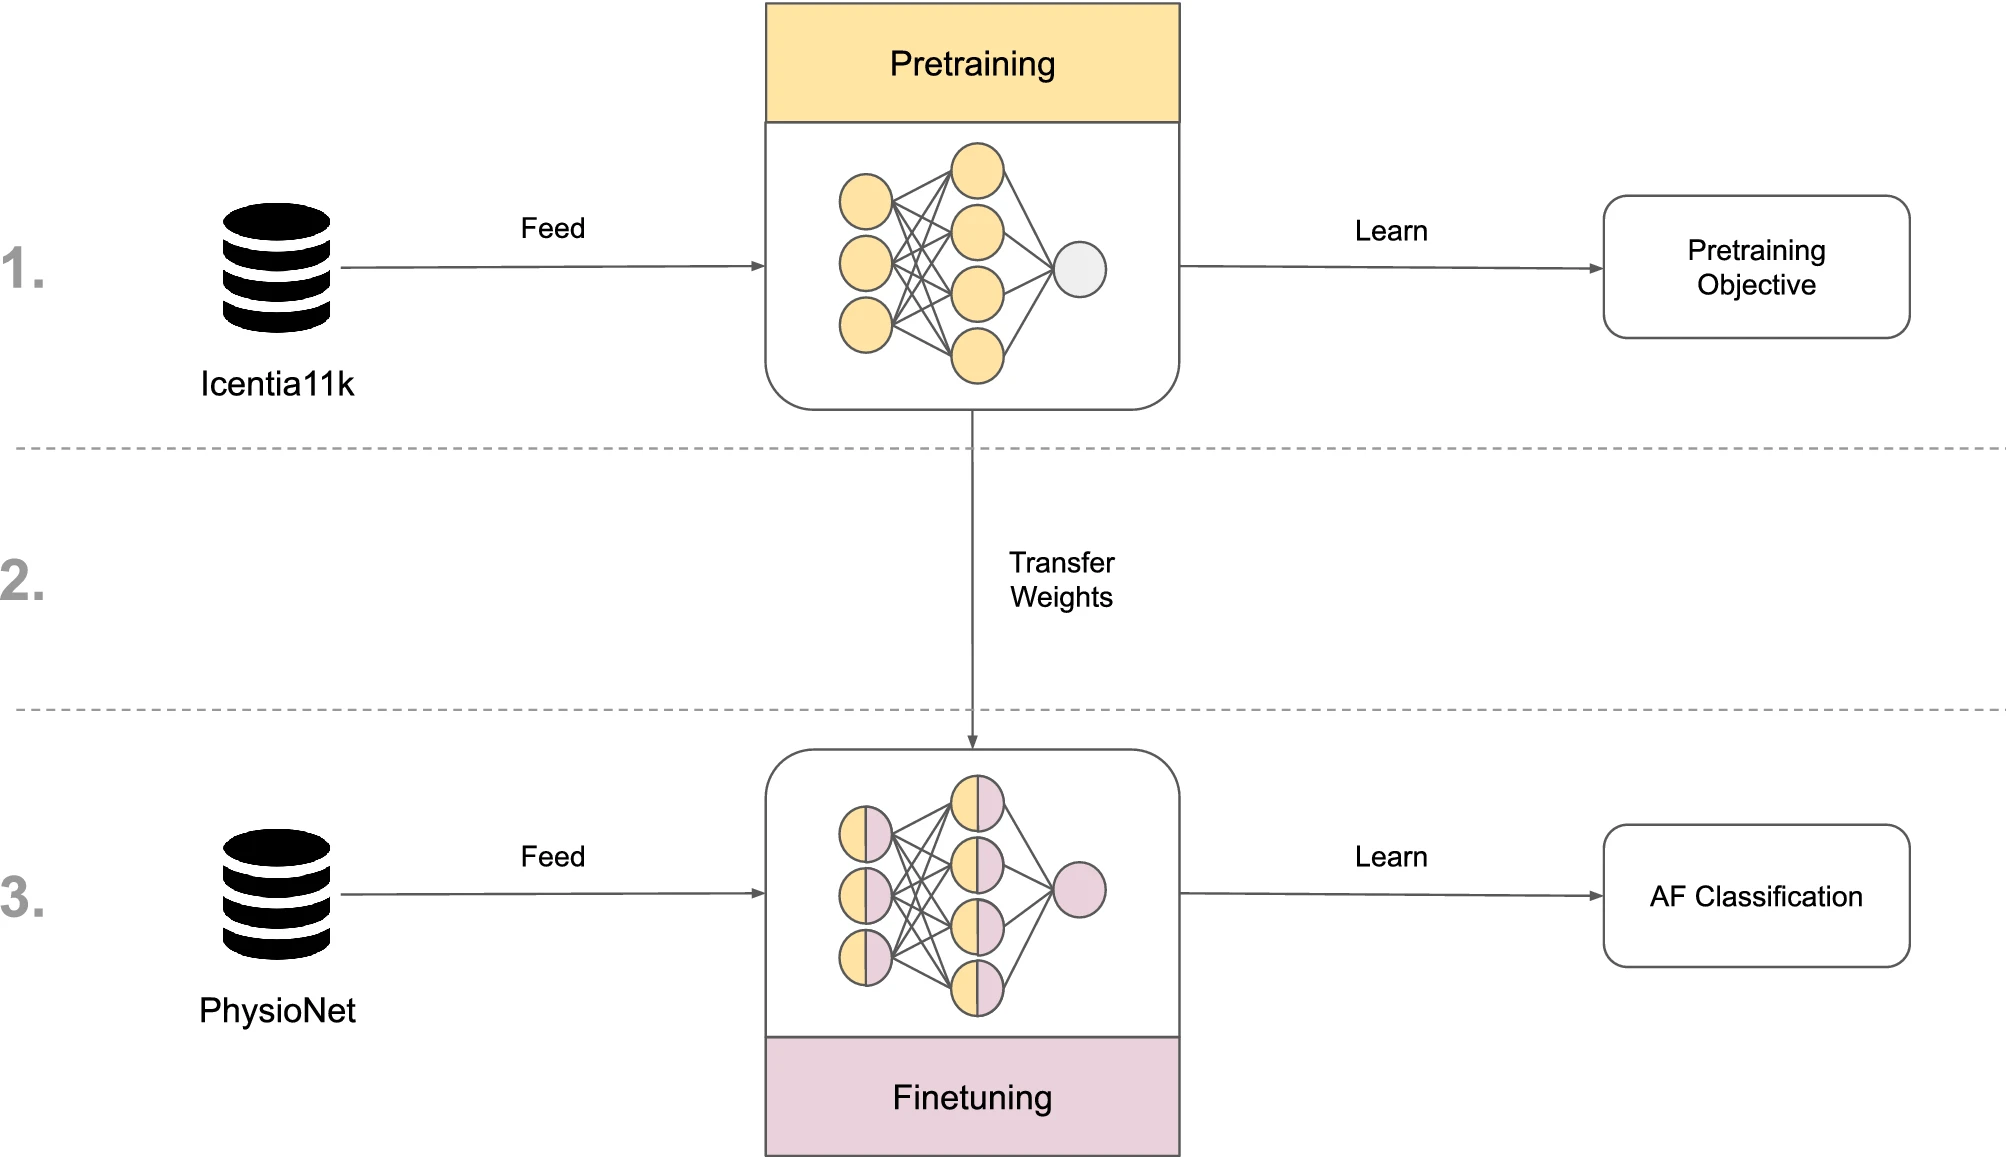

In [10]:
from google.colab.patches import cv2_imshow
import cv2
'''
if you want to use an image outside this notebook for explanaition,
you can upload it to your google drive and show it with OpenCV or matplotlib
'''
# mount this notebook to your google drive
#drive.mount('/content/gdrive')

# define dirs to workspace and data
img_dir = '/content/drive/MyDrive/DL4H/transferlearning1.png'

img = cv2.imread(img_dir)

cv2_imshow(img)



# Methodology

The core parts of this paper involve the below steps.



1.   Step 1 - Pretraining residual CNN on large raw ECG data availabe in Icentia11k dataset[2], the dataset has size roughly 272GB.
2.   Step 2 - Finetuning the residual network for ECG classification for a smaller dataset PhysioNet/CinC 2017 data set [3][4] of size 1.4 GB.
3.   Step 3 - Use the pretrained model to implement ECG classification on a downstream dataset PTB-XL database [5] for related ECG classification in this case, heart beat classification.
4.   Step 4 - If time permits, Study the transformer architecture with attention model to check the future prediction of ECG frames to better use the economical unsupervisied mode for ECG classification.



In [4]:
# Important note - we plan to use the code provided by authors here- https://github.com/kweimann/ecg-transfer-learning/tree/master
# we will import the necessary code to display the model, data set statistics and experiments specified in the paper.

In [23]:
# import  packages you need
import numpy as np
import tensorflow as tf
import pandas as pd



In [ ]:
# Below we install some package required for the orignal paper git repo code (repo code).
# One thing we noticed is the repo code has a dependency on samplerate, which requires cmake to build.
# For some stange reason pip would complain cmake not existing despite the opposite.
# We found a solution by unstall cmake first, then install samplerate. This resolves the issue.
# Separately, we also need to install another dependency wfdb, which runs smoothly.

In [19]:
#Execution code commented, since this is required only first time.

# step 1
# !pip uninstall --verbose cmake
# # step 2 These are based on requirements.txt from source project
# !pip install --verbose samplerate
# # step 3
# !pip install --verbose wfdb

# # not used: update torch summary, maybe to print model dimension?
# !pip install --verbose torchsummary

# !pip install tensorflow
# !pip install h5py
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install scipy
# !pip install tqdm


#  Step 1 - PreTraining

Goal - DNN's will generalize better to unseen data after encountering wide variety of ECG signals during pretraining.

## Source of Input Data:
Publicly available Icentia11K [2], the dataset has size roughly 272GB.
Raw Dataset available at : https://academictorrents.com/details/af04abfe9a3c96b30e5dd029eb185e19a7055272


## Input Data Statistics[2]


* No of Patients:       11000
* No of Labeled Beats:  2,774,054,987
* Sample Rate:          250 Hz
* Frame Size:           2049 Samples
* Segment Size:         1,048,577 Samples
* No of Frames:         1,084,314
* No of Segments:       542,157
* Dataset Size:         271.27 GB






TODO --

3. Downstream Datasets for additional classification tasks - The paper uses two distinct datasets for this part: PTB-XL database [5], and a dataset released in 1st China Physiological Signal Challenge 2018 [8]. In this production attempt, in the interest of brevity, we will explore with PTB-XL dataset, a dataset of size 1.8G in a zip file.


## Upload of raw data for pretraining?

No, due to large size of input data, we have run the pretraining steps on on our local machine and uploaded the weights to google drive, we plan to use these pre-trained files for rest of our pipelines.



In [27]:
# Feature Extraction and data processing for pretraining
#.  1. Select random no of patients.
#   2. Collect mini batches by sampling short ECG frames(around 60 seconds)
#.  3. Standardize each frame using meand and standard deviation of entire dataset, results in 4096 frames/ Patient.
#   4. Pretraining using both resNet18 and resNet34 architecture,
       #the paper only uses single epoch but we have pretrained on 10 epochs.
#.  5. Pick the best accuracy epoch for extracting weights,
       #we will illustratate this from google drive jobs/<beats_mulitple_epochs-<34>_classification/history.csv>

df = pd.read_csv('jobs/hr_classification/history.csv')
df

,epoch,acc,loss,val_acc,val_loss
0,0,0.788125,0.6023,NaN,NaN


In [29]:
# Beat Classification - Feature Extraction and data processing for pretraining
# from google drive jobs/<beats_mulitple_epochs-<34>_classification/history.csv>
# save the checkpoint weights for beat classification for resNet18 and resNet34

# Input Data: Short ECG Frame


# Classification class Labels : Normal,
                    #         : Premature Atrial Contraction,
                    #         : Premature Ventrical Contraction

from pretraining.utils import get_pretrained_weights


#Execution code commented since processing files are available in gdrive.


# resnet18 = get_pretrained_weights(
#    checkpoint_file='jobs/beat_multiple_epochs_classification/epoch_10_model.weights.h5',
#    task='beat',
#    arch='resnet18')
# resnet18.save_weights('jobs/beat_classification/resnet18.weights.h5')



# resnet34 = get_pretrained_weights(
#    checkpoint_file='jobs/beat_multiple_epochs_34_classification/epoch_06_model.weights.h5',
#    task='beat',
#    arch='resnet34')
# resnet34.save_weights('jobs/beat_classification/resnet34.weights.h5')

# The weights are already available in Google Drive
# resNet18 - jobs/beat_classification/resnet18.weights.h5
# resNet34 - jobs/beat_classification/resnet34.weights.h5



In [ ]:
# Rhythm Classification - Feature Extraction and data processing for pretraining
# from google drive jobs/<rhythm_mulitple_epochs-<34>_classification/history.csv>
# save the checkpoint weights for beat classification for resNet18 and resNet34

# Input Data: Short ECG Frame

# How is this measured? Duration of every rhythm to determine the label.


# Classification class Labels : Normal,
                    #         : Noise,
                    #         : Atrial Fibrillation AFlib
                    #         : Atrial Flutter AFlutter


#Execution code commented since processing files are available in gdrive.

# resnet18 = get_pretrained_weights(
#    checkpoint_file='jobs/rhythm_classification/epoch_01_model.weights.h5',
#    task='rhythm',
#    arch='resnet18')
# resnet18.save_weights('jobs/rhythm_classification/resnet18.weights.h5')



# resnet34 = get_pretrained_weights(
#    checkpoint_file='jobs/rhythm_multiple_epochs_34_classification/epoch_10_model.weights.h5',
#    task='rhythm',
#    arch='resnet34')
# resnet34.save_weights('jobs/rhythm_classification/resnet34.weights.h5')


# The weights are already available in Google Drive
# resNet18 - jobs/rhythm_classification/resnet18.weights.h5
# resNet34 - jobs/rhythm_classification/resnet34.weights.h5



In [22]:
# Heart Rate Classification - Feature Extraction and data processing for pretraining
# from google drive jobs/<hr_mulitple_epochs-<34>_classification/history.csv>
# save the checkpoint weights for beat classification for resNet18 and resNet34

# What is measured? Estimate no of Beats/ Min

# How is this feature extracted?
#                     The labels are auto generated.
#                     find indices of heart beat using QRS Algorithm[35 in paper]
#                     Extend frame by 1 second at both ends.

# Input Data: Short ECG Frame

# Classification class Labels : Normal (60-100),
                    #         : Noise,
                    #         : Tachycardia (>100)
                    #         : Bradycardia (<60)


#Execution code commented since processing files are available in gdrive.


# resnet18 = get_pretrained_weights(
#    checkpoint_file='jobs/hr_classification/epoch_01_model.weights.h5',
#    task='hr',
#    arch='resnet18')
# resnet18.save_weights('jobs/hr_classification/resnet18.weights.h5')



# resnet34 = get_pretrained_weights(
#    checkpoint_file='jobs/hr_multiple_epochs_34_classification/epoch_09_model.weights.h5',
#    task='hr',
#    arch='resnet34')
# resnet34.save_weights('jobs/hr_classification/resnet34.weights.h5')


# The weights are already available in Google Drive
# resNet18 - jobs/hr_classification/resnet18.weights.h5
# resNet34 - jobs/hr_classification/resnet34.weights.h5

In [ ]:
# dir and function to load processed data


''' you can load the processed data directly
processed_data_dir = '/content/gdrive/My Drive/Colab Notebooks/<path-to-raw-data>'
def load_processed_data(raw_data_dir):
  pass

'''

##   Model
The paper uses two main models.

1.   Residual Network CNN for pretraining and finetuning.
2.   Attention based transformer architecture for unsupervised learning.

The core claim and contribution of the paper deals with applying transfer learning from large datasets to accomplish ECG classifications on smaller datasets where the need for supervised labels is minimized. For this we only need to study the Residual network for both pretraining and finetuning modes.

We will pretrain our model on two architecture types resNet18 and resNet34, the computation and layers of resNet50 would be too complex to train and evaluate due to size of input dataset and compute capacity limitations.



TODO
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.



The paper proposes a Transfer Learning structure. It learns on large amount of data, but with less annotation, as a pretraining, then on a smaller, but better curated dataset, we transfer the weights learnt from the pre-training stage, and fine-tuned it for the downstream tasks.

For the pretraining phase, the paper uses a ResNet18 structure, trained on Icentia11K dataset.



In [16]:
# Pretraining - Residual Network, ResNet18 considered as shallow network

#%run https://github.com/kweimann/ecg-transfer-learning/blob/master/finetuning/utils.py

# The core residual network comes from the well documented base network here[6] -
# He, K., Zhang, X., Ren, S., & Sun, J. Identity Mappings in Deep Residual Networks (2016). arXiv:1603.05027.


# The following modifications are made from the base Model
#. 1. Replace 2-d Convolution layers with 1-d counterparts for ECG data.
#  2. Larger filter sizes 7,5,5,3 at each stage instead of default size 3.
#


from transplant.modules.resnet1d import ResNet

stages=None
resnet_18 = ResNet(num_outputs=None,
                        blocks=(2, 2, 2, 2)[:stages],
                        kernel_size=(7, 5, 5, 3),
                        include_top=False)

input_shape = (1,1,64)
resnet_18.build(input_shape)
print(resnet_18.summary())

Model: "res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           multiple                  28672     
                                                                 
 batch_normalization_1 (Bat  multiple                  256       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              multiple                  0         
                                                                 
 max_pooling1d_1 (MaxPoolin  multiple                  0         
 g1D)                                                            
                                                                 
 residual_block_8 (Residual  multiple                  57856     
 Block)                                                          
                                                         

In [30]:
# class my_model():
#   # use this class to define your model
#   pass

# model = my_model()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer =tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def train_model_one_iter(model, loss_func, optimizer):
  pass

num_epoch = 10
# model training loop: it is better to print the training/validation losses during the training
# for i in range(num_epoch):
#   train_model_one_iter(model, loss_func, optimizer)
#   train_loss, valid_loss = None, None
#   print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))


# Step 2 - FineTuning Data and Model Section

## Input data:

Smaller target dataset for AF classification - PhysioNet/CinC 2017 data set [3][4].
Sample Rate:            300 Hz
Dataset Size:           1.4 GB
Test dataset available: No
Duration of Signal:     9-60 seconds.


## Data Split:
For the purpose of fine-tuning, the dataset has been splitted to 80/20 between training and testing.

## Target ECG classification
AF classification

## Location of dataset

Uploaded the file to Gdrive and attached to this notebook as a mount.

In [38]:
# Step 2 Finetuning

#Data preprocessing Steps:

# 1. Standardize signal using mean and standard deviation across the dataset.
# 2. Down Sampling from 300 to 250 Hz to match the Icentia11k dataset.
# 3. Pad some recording with zeros to have signal length of 60 seconds.
# 4. 75% training data, 20% Test and 5% validation splits with class balanced ratios.


from finetuning import datasets
from finetuning.utils import train_test_split
from transplant.utils import save_pkl

#Execution code commented due to resource constraint.

# data = datasets.get_challenge17_data(
#    db_dir='data/physionet',
#    fs=250,  # keep sampling frequency the same as Icentia11k
#    pad=16384,  # zero-pad recordings to keep the same length at about 65 seconds
#    normalize=True)  # normalize each recording with mean and std computed over the entire dataset
# # maintain class ratio across both train and test sets by using the `stratify` argument
# train_set, test_set = train_test_split(
#    data, test_size=0.2, stratify=data['y'])
# save_pkl('data/physionet_train.pkl', **train_set)
# save_pkl('data/physionet_test.pkl', **test_set)



# Caution - The Above code is taking too long to upload and execute in colab,
#i have uploaded the files from local, it was executed with exact same code.
# My Drive/DL4H/data will have the two files data/physionet_train.pkl and
# data/physionet_test.pkl




In [40]:
# Step 2 - FineTuning Model Modifications

#Pre - FineTuning Steps:


# Replace CNN output layer with Fully connected later with random weights,
# ensure the output matches the classes of finetuning dataset.

# FineTuning - Start

#Train CNN for upto 200 epochs, 50 epochs limit for accuracy metric improvement.
# If no imporvement for 50 epochs, stop training.

!python -m finetuning.trainer \
--job-dir "jobs/af_classification" \
--train "data/physionet_train.pkl" \
--test "data/physionet_test.pkl" \
--weights-file "jobs/beat_classification/resnet18.weights.h5" \
--val-size 0.0625 \
--arch "resnet18" \
--batch-size 64 \
--epochs 200




# Record macro F1 Score.


# FineTuning - End.

# Revert weights of network to checkpoint at model at highest macro F1 score
# on Val set.




# Finally
from transplant.evaluation import f1
from transplant.utils import read_predictions
test = read_predictions('jobs/af_classification/test_predictions.csv')
y_true = test['y_true']
y_prob = test['y_prob']
print(f1(y_true, y_prob))

# Record macro F1 score on Test Set.

#end Finetuning

2024-04-14 01:45:34.772482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 01:45:34.772558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 01:45:34.775805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 01:45:36.354409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in jobs/af_classification
Setting random state 23192
Loading train data from data/physionet_train.pkl ...
file: data/physionet_train.pkl
Split data into train 93.74% and validation 6.26%
Loading test data from data

# Step 3 - Downstream Dataset Classification

## Input Data Source:

 PTB-XL database [5]
 dataset of size 1.8G in a zip file.

## Traget Classification

Heart Beat Classification.


# Evaluate Pre Training methods

We have following pre training methods for evaluation



1.   Beat Classification
2.   Hr Classification
3.   Rhythm Classification.
4.   Stretch Goal - Future Prediction based on Transformer Architecture.

## Abalations Scope Evaluation



1.   Remove PreTraining and try ECG classification on af classification dataset, so random weights method.



In [ ]:
# Evaluation of pre training methods

# For each method call finetuning in above section.

#. Epoch : 10 times.
#.        For each Run:
#                      1. new Train and validation sets.
#                      2. adjust output layers based on method. beat vs hr vs rhythm.
#                      3. finetune model.
#                      4. record macro f1 score on Test Set.
#

# Results
We are not ready to include the results and analyses yet due to pending verification of downstream data sets and finetuning tasks for all modes of pretraining methods.

Once we complete the above activities we expect to fill the below table



In [ ]:
# metrics to evaluate my model

from sklearn.metrics import roc_auc_score, f1_score


#Macro F1 Score and Accuracy are main metrics used and we plan to plot the results for specific pretraining method

#Pre Training Methods: beat_classification, rhythm_classification,
#                      hr_classification, random_weights_without_preTraining
#     if time permits, future_prediction_classification.

#Metrics Tracked: Macro F1 Score

# datasets :  PhysioNet/CinC 2017 data set [3][4]
#             PTB-XL database [5]

# Residual Network Architectures  : resNet18
#                                 : resNet34

# it is better to save the numbers and figures for your presentation.

## Future Prediction Model Discussion



1.   In case time permits, we plan to discuss our finding's on the auxillary experiment of the paper where in one of the pretraining methods a attention based transformer model is used to predict a future ECG frame based on current ECG frame and some context frames.
2.   During the study of this section we also plan to report on our understanding of Contrastive Predictive Coding from Computer vision space and how this principle was used for ECG data.





# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

Instruction: https://colab.research.google.com/notebooks/io.ipynb

Example: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

Video: https://www.youtube.com/watch?v=zc8g8lGcwQU

# References

1. Weimann, K., Conrad, T.O.F. Transfer learning for ECG classification. Sci Rep 11, 5251 (2021). https://doi.org/10.1038/s41598-021-84374-8 https://github.com/kweimann/ecg-transfer-learning/tree/master

2. Tan, S. et al. Icentia11K: An Unsupervised Representation Learning Dataset for Arrhythmia Subtype Discovery (2019). arXiv:arXiv:1910.09570

3. Clifford, G. D. et al. AF Classification from a short single lead ECG recording: the PhysioNet/computing in cardiology challenge 2017. Comput. Cardiol. (2017).In 2017 Computing in Cardiology (CinC) 2017 Sep 24 (pp. 1-4). IEEE. https://doi.org/10.22489/CinC.2017.065-469

4. Goldberger, A. L. et al. PhysioBank, PhysioToolkit, and PhysioNet: components of a new research resource for complex physiologic signals. Circulation 101, e215–e220. https://doi.org/10.1161/01.CIR.101.23.e215 (2000).

5. Strodthoff, N., Wagner, P., Schaeffter, T., & Samek, W. Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL (2020). arXiv:2004.13701.

6. van den Oord, A., Li, Y., & Vinyals, O. Representation Learning with Contrastive Predictive Coding (2019). arXiv:1807.03748.

7. He, K., Zhang, X., Ren, S., & Sun, J. Deep Residual Learning for Image Recognition (2015). arXiv:1512.03385.

8. Liu, F. et al. An open access database for evaluating the algorithms of electrocardiogram rhythm and morphology abnormality detection. J. Med. Imaging Health Inf. 8, 1368–1373. https://doi.org/10.1166/jmihi.2018.2442 (2018).

9. Mayo Clinic Staff, Mayo Clinic in Rochester, Minnesota, Electrocardiogram (ECG or EKG), https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983



# Feel free to add new sections